In [2]:
library(ppcor)
#install.packages('lmPerm')
library(lmPerm)
library(psych)
library(car)
library(ggplot2)
library(lme4)
library(mediation)
library(caret)
library(gbm)
library(party)
library(Metrics)
#install.packages("wesanderson")
library(wesanderson)
library(gtools)
library(interactions)
#install.packages('ggstance')
library(ggstance)
#install.packages('elasticnet')
library(elasticnet)
#install.packages('kernlab')
library(kernlab)
#install.packages('e1071')
library(e1071)
#install.packages('MatchIt')
library(MatchIt)
library(dplyr)
library(ukbtools)
library(mediation)
library(lavaan)
library(lavaanPlot)
library(plotly)
library(MVN)
#install.packages('MissMech')
library(semTools)
library(MissMech)
#install.packages('aod')
library(aod)


In [279]:
a=c(1, 1, 3, 5, 4, 6, 4)

In [284]:
a[!duplicated(a)]

[1] 1 3 5 4 6

# Read in the data 

In [291]:
#di=read.table('/dagher/dagher11/filip/PRSOB/data/brain_data.csv', header=TRUE, na.strings = "", sep=',', quote = "\"")
cov19=read.table('/dagher/dagher11/filip/PRSOB/data/covid19_result.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
cov19= cov19[order(cov19$result, decreasing=TRUE),] 

covidinf=cov19
covidinf=covidinf[!duplicated(covidinf$eid),]
cov19$date=as.Date( as.character(cov19$specdate), "%d/%m/%y")
cov19 <- subset(cov19, date <= as.Date("2020-04-26") ) # filter participants before April 26th
cov19=cov19[!duplicated(cov19$eid),]

## Add hypertension and diabetes diagnosis

In [292]:
di$hypertension <- 0
for (i in as.numeric(grep('vascularheart_problems_diagnosed_by_doctor', colnames(di)))) { 
    di$hypertension[di[i] == 'High blood pressure'] <- 1 # Hypertension
}

# Mark participants who have diabetes - self-reported
di$diabetes <- 0
for (i in as.numeric(grep('diabetes_diagnosed_by_doctor', colnames(di)))) { 
    di$diabetes[di[i] =="Yes"] <- 1
}

# Mark participants with hypertension - diagnosed
di$hypertension2 <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) { 
    di$hypertension2[di[i] == 'I10 Essential (primary) hypertension'] <- 1 # Hypertension
    }

# Mark participants who have diabetes - diagnoses
exclusions_diabetes=c('^E10','^E11','^E12','^E13','^E14')
di$diabetes2 <- NA
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(exclusions_diabetes)) {
        di$diabetes2[grepl(exclusions_diabetes[d], di[[i]])] = 1
    }
}

di$Hypertension=0
di$Hypertension[di$hypertension=='1' | di$hypertension2=='1']=1
di$Diabetes=0
di$Diabetes[di$diabetes=='1' | di$diabetes2=='1']=1

# MetS latent variable and OR - covid infection

In [293]:
covidinf=merge(di,covidinf,by='eid')

In [302]:
covidinf$TG=(log(covidinf$triglycerides_30870.0.0))
covidinf$HDL=(log(covidinf$hdl_cholesterol_30760.0.0))
covidinf$Sex=as.factor(covidinf$sex_31.0.0)
covidinf$Waist=(covidinf$waist_circumference_48.0.0)
covidinf$HbA1c=(log(covidinf$glycated_haemoglobin_hba1c_30750.0.0))
covidinf$systolicBP=(rowMeans(cbind(covidinf$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covidinf$systolic_blood_pressure_automated_reading_4080.0.1)))
covidinf$diastolicBP=(rowMeans(cbind(covidinf$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covidinf$diastolic_blood_pressure_automated_reading_4079.0.1)))
covidinf$glucose=(log(covidinf$glucose_30740.0.0))
covidinf$CRP=(log(covidinf$c.reactive_protein_30710.0.0))


COVinf=select(covidinf, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, eid)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}

COVinf=na.omit(COVinf)

COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

nrow(COVinf)

[1] 3081

## Sample characteristics

In [317]:
char=merge(COVinf, covidinf, by='eid', all.x=TRUE)
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(COVinf)
describe(char$waist_circumference_48.0.0)
describe(char$glycated_haemoglobin_hba1c_30750.0.0)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0)
describe(char$hdl_cholesterol_30760.0.0)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(covid$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covid$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(covid$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covid$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(COVinf)
table(char$Hypertension.x)/nrow(COVinf)


       0        1 
0.714703 0.285297 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,1951.24,8.885971,1949,1950.804,10.3782,1937,1970,33,0.3638221,-1.144821,0.1600881



  Female     Male 
0.507952 0.492048 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,92.64843,14.2845,92,92.10953,14.826,58,146,88,0.3617656,-0.002896251,0.2573471


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,35.76628,4.470055,35.4,35.5297,3.85476,23.5,54.7,31.2,0.7228608,1.721622,0.08053173


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,2.915102,4.846994,1.52,1.95742,1.423296,0.09,66.24,66.15,6.06055,53.51716,0.08732259


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,5.000596,0.6419376,4.941,4.95483,0.541149,3.229,7.704,4.475,0.8531772,1.656717,0.01156504


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,1.409282,0.3731413,1.364,1.381913,0.363237,0.547,3.336,2.789,0.8047044,1.067934,0.006722449


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,3081,1.758347,1.024888,1.493,1.607161,0.7753998,0.362,9.786,9.424,1.891008,5.924092,0.01846421


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,2313,138.1016,19.3797,136,137.1126,18.5325,89,222.5,133.5,0.6157871,0.7517728,0.4029576


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,2313,82.31885,10.35101,82,82.07509,10.3782,49,127,78,0.2962185,0.3257638,0.2152261



         0          1 
0.91236611 0.08763389 


        0         1 
0.5770854 0.4229146 

## CFA

In [303]:
COVID_infection = '
#Latent variables

BP =~ diastolicBP + systolicBP 
HypertensionLatent =~  BP + Hypertension
DiaSer =~ HbA1c + glucose 
DiabetesLatent =~ DiaSer + Diabetes
DysL =~ TG + HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP




'

COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 57 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         25
                                                      
  Number of observations                          3081
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                               518.416     488.734
  Degrees of freedom                                30          30
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.061
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                              6708.976    5947.052
  Degrees of freedom                                45          45
  P-value                        

### Get latent variable scores

In [304]:
COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,6]

### Run logistic regression

In [536]:
metsinf_logit=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6131  -0.8361  -0.6569   1.1807   2.2710  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -22.860484
townsend_deprivation_index_at_recruitment_189.0.0                                0.085357
MetS                                                                             0.133100
sex_31.0.0Male                                                                   0.233333
year_of_birth_34.0.0                                                

In [537]:
metsinf_logit_specfactors=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           systolicBP + diastolicBP + Hypertension +
           glucose + HbA1c + Diabetes +
           HDL + TG +
           CRP +
           Waist +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit_specfactors)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    systolicBP + diastolicBP + Hypertension + glucose + HbA1c + 
    Diabetes + HDL + TG + CRP + Waist + sex_31.0.0 + year_of_birth_34.0.0 + 
    laboratory + spectype + qualifications_6138.0.0 + smoking_status_20116.0.0 + 
    ethnic_background_21000.0.0 + average_total_household_income_before_tax_738.0.0, 
    family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6326  -0.8340  -0.6529   1.1806   2.2895  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -1.850e+01
townsend_deprivation_index_at_recruitment_189.0.0                               9.029e-02
systolicBP                                                                     -3.477e-02
diastolicBP                                                     

### Get odds ratio with CIs

In [538]:
ORs_MetS=exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))  

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

In [539]:
ORs_infection=exp(cbind(coef(metsinf_logit_specfactors), confint(metsinf_logit_specfactors)))  

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

## Plot ORs for infection

In [540]:
library(wesanderson)
library(ggplot2)

ORs_infection=data.frame(ORs_infection)
ORs_infection$names <- rownames(ORs_infection)
ORs_infection=ORs_infection[3:12,]
ORs_infection$names=factor(ORs_infection$names, ordered=T)
ORs_infection$names=c('Systolic BP','Diastolic BP','Hypertension diagnosis','Serum glucose','HbA1c',
                     'Diabetes diagnosis', 'HDL','TG','CRP','Waist circumference')


ORs_infection$Symptomsgroup=c('Hypertension','Hypertension','Hypertension','Diabetes',
                      'Diabetes','Diabetes','Dyslipidemia','Dyslipidemia','Inflammation','Waist circumference')

In [541]:
ORs_MetS=data.frame(ORs_MetS)
ORs_MetS$names <- rownames(ORs_MetS)
ORs_MetS$names=factor(ORs_MetS$names, ordered=T)
ORs_MetS=ORs_MetS[3,]
ORs_MetS$names=c('Metabolic syndrome')
ORs_MetS$Symptomsgroup=c('Metabolic syndrome')

ORs_infection=rbind(ORs_infection, ORs_MetS)

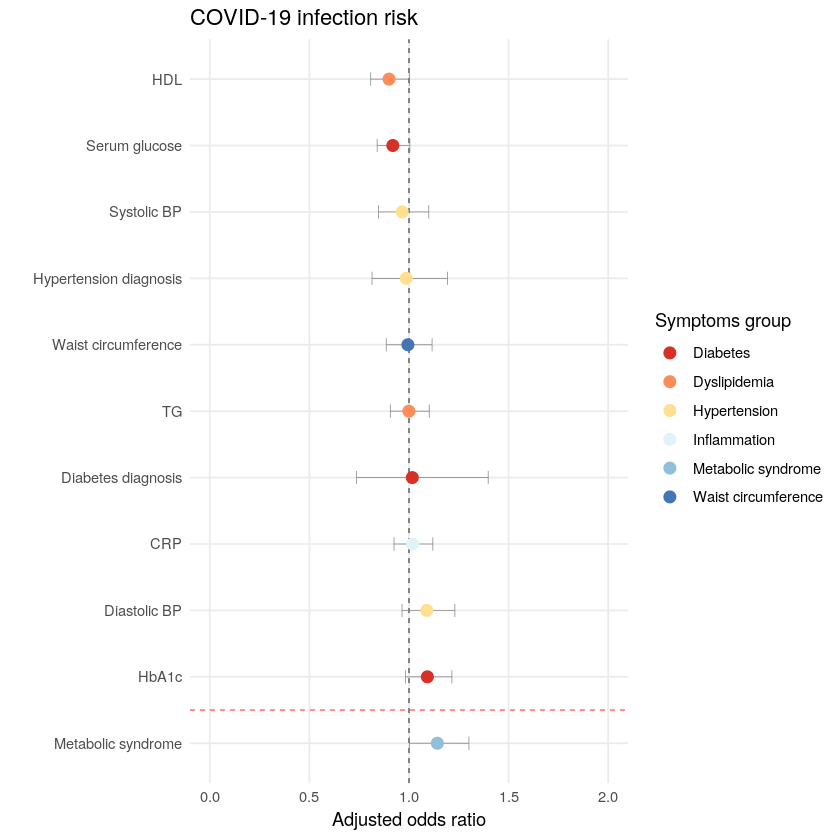

In [556]:
(p <- ggplot(ORs_infection, aes(x = (V1), y = reorder(names, -V1))) + 
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmax = X97.5.., xmin = X2.5..), size = 0.2, height = 0.2, color = "gray50") +
    geom_point(size = 3, aes(color = Symptomsgroup)) +
    scale_x_continuous(breaks = c(0,0.5,1,1.5,2),
                       limits = c(0,2)) +
    theme_minimal() +
    theme(panel.grid.minor = element_blank()) +
    ylab("") +
    xlab("Adjusted odds ratio") + 
    ggtitle("COVID-19 infection risk") +
    scale_color_brewer(palette="RdYlBu", name='Symptoms group') +
    geom_hline(aes(yintercept = 1.5), size = .25, color='red', linetype='dashed') 
 )

ggsave('/dagher/dagher11/filip/COVID/COVID_infection.tiff',
  plot = p,
  device = 'tiff',
  scale = 1,
  width = 15,
  height = 10,
  units = 'cm',
  dpi = 300
)

# MetS latent variable and OR - covid hospitalisation

In [308]:
covid=merge(di,cov19,by='eid')

covid$TG=(log(covid$triglycerides_30870.0.0))
covid$HDL=(log(covid$hdl_cholesterol_30760.0.0))
covid$Sex=as.factor(covid$sex_31.0.0)
covid$Waist=(covid$waist_circumference_48.0.0)
covid$HbA1c=(log(covid$glycated_haemoglobin_hba1c_30750.0.0))
covid$systolicBP=(rowMeans(cbind(covid$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covid$systolic_blood_pressure_automated_reading_4080.0.1)))
covid$diastolicBP=(rowMeans(cbind(covid$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covid$diastolic_blood_pressure_automated_reading_4079.0.1)))
covid$glucose=(log(covid$glucose_30740.0.0))
covid$CRP=(log(covid$c.reactive_protein_30710.0.0))

In [309]:
COV=select(covid, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, eid)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COV[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COV[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COV[j][COV[j]<lower]=NA
    COV[j][COV[j]>upper]=NA
    COV[j]=scale(COV[j])
}

COV=na.omit(COV)

COV$Hypertension=as.numeric(COV$Hypertension)
COV$Diabetes=as.numeric(COV$Diabetes)
nrow(COV)

[1] 1669

## Sample characteristics

In [310]:
char=merge(COV, covid, by='eid', all.x=TRUE)
table(char$result.x)/nrow(COV)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(COV)
describe(char$waist_circumference_48.0.0)
describe(char$glycated_haemoglobin_hba1c_30750.0.0)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0)
describe(char$hdl_cholesterol_30760.0.0)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(covid$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covid$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(covid$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covid$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(COV)
table(char$Hypertension.x)/nrow(COV)


        0         1 
0.5991612 0.4008388 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,1951.216,8.886722,1949,1950.783,10.3782,1937,1970,33,0.3703642,-1.15143,0.2175271



   Female      Male 
0.4865189 0.5134811 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,93.67513,14.18278,93,93.19843,13.3434,60,142,82,0.3501912,0.02743312,0.3471628


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,35.9562,4.543202,35.5,35.67734,3.85476,23.5,54.3,30.8,0.7650679,1.57095,0.1112075


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,3.078149,5.043191,1.6,2.072139,1.512252,0.1,66.24,66.14,5.946721,52.2501,0.1234461


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,5.001368,0.6568895,4.943,4.953989,0.5441142,3.229,7.75,4.521,0.846757,1.6162,0.01607919


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,1.392848,0.3660244,1.35,1.366812,0.3587892,0.616,3.123,2.507,0.7445539,0.7364973,0.00895946


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1669,1.778738,1.054987,1.506,1.617222,0.770952,0.461,9.786,9.325,1.994766,6.57126,0.02582373


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,2313,138.1016,19.3797,136,137.1126,18.5325,89,222.5,133.5,0.6157871,0.7517728,0.4029576


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,2313,82.31885,10.35101,82,82.07509,10.3782,49,127,78,0.2962185,0.3257638,0.2152261



         0          1 
0.90832834 0.09167166 


       0        1 
0.561414 0.438586 

## CFA

In [311]:
COVID_SEM = '
#Latent variables

BP =~ diastolicBP + systolicBP
HypertensionLatent =~  BP + Hypertension
DiaSer =~ HbA1c + glucose
DiabetesLatent =~ DiaSer + Diabetes
DysL =~ TG + HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP



'

COVID_fit <- cfa(COVID_SEM, data=COV, estimator='MLM')
summary(COVID_fit, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 56 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         25
                                                      
  Number of observations                          1669
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                               292.374     270.459
  Degrees of freedom                                30          30
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.081
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                              3517.736    3136.805
  Degrees of freedom                                45          45
  P-value                        

### Get latent variable scores

In [312]:
COV$MetS=(lavPredict(COVID_fit, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,6]

### Run logistic regression

In [504]:
mets_logit=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COV, family='binomial'(link="logit")))

summary(mets_logit)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COV)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7325  -0.9917  -0.7700   1.2075   1.9012  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -21.753464
townsend_deprivation_index_at_recruitment_189.0.0                                0.052004
MetS                                                                             0.192846
sex_31.0.0Male                                                                   0.272610
year_of_birth_34.0.0                                                   

In [505]:
metsinf_logit_specfactors=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
           systolicBP + diastolicBP + Hypertension +
           glucose + HbA1c + Diabetes +
           HDL + TG +
           CRP +
           Waist +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COV, family='binomial'(link="logit")))

summary(metsinf_logit_specfactors)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0 + 
    systolicBP + diastolicBP + Hypertension + glucose + HbA1c + 
    Diabetes + HDL + TG + CRP + Waist + sex_31.0.0 + year_of_birth_34.0.0 + 
    laboratory + spectype + qualifications_6138.0.0 + smoking_status_20116.0.0 + 
    ethnic_background_21000.0.0 + average_total_household_income_before_tax_738.0.0, 
    family = binomial(link = "logit"), data = COV)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7476  -0.9891  -0.7602   1.1898   1.8920  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -21.338514
townsend_deprivation_index_at_recruitment_189.0.0                                0.062660
systolicBP                                                                      -0.018417
diastolicBP                                                        

### Get odds ratio

In [520]:
ORs_MetS=exp(cbind(coef(mets_logit), confint(mets_logit)))  

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

In [521]:
ORs_hospital=exp(cbind(coef(metsinf_logit_specfactors), confint(metsinf_logit_specfactors)))  

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

## Plot ORs for hospitalization

In [522]:
ORs_hospital=data.frame(ORs_hospital)
ORs_hospital$names <- rownames(ORs_hospital)
ORs_hospital=ORs_hospital[3:12,]
ORs_hospital$names=factor(ORs_hospital$names, ordered=T)
ORs_hospital$names=c('Systolic BP','Diastolic BP','Hypertension diagnosis','Serum glucose','HbA1c',
                     'Diabetes diagnosis', 'HDL','TG','CRP','Waist circumference')

ORs_hospital$Symptomsgroup=c('Hypertension','Hypertension','Hypertension','Diabetes',
                      'Diabetes','Diabetes','Dyslipidemia','Dyslipidemia','Inflammation','Waist circumference')


In [523]:
ORs_MetS=data.frame(ORs_MetS)
ORs_MetS$names <- rownames(ORs_MetS)
ORs_MetS$names=factor(ORs_MetS$names, ordered=T)
ORs_MetS=ORs_MetS[3,]
ORs_MetS$names=c('Metabolic syndrome')
ORs_MetS$Symptomsgroup=c('Metabolic syndrome')

ORs_hospital=rbind(ORs_hospital, ORs_MetS)

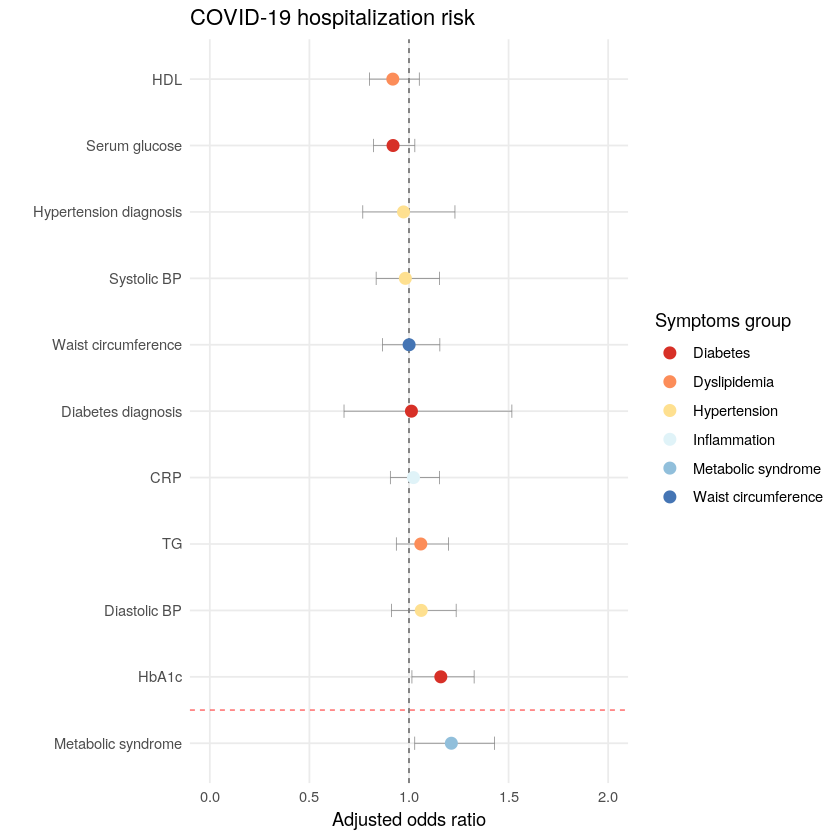

In [557]:
(p <- ggplot(ORs_hospital, aes(x = (V1), y = reorder(names, -V1))) + 
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmax = X97.5.., xmin = X2.5..), size = 0.2, height = 0.2, color = "gray50") +
    geom_point(size = 3, aes(color = Symptomsgroup)) +
    scale_x_continuous(breaks = c(0,0.5,1,1.5,2),
                       limits = c(0,2)) +
    theme_minimal() +
    theme(panel.grid.minor = element_blank()) +
    ylab("") +
    xlab("Adjusted odds ratio") + 
    ggtitle("COVID-19 hospitalization risk") +
    scale_color_brewer(palette="RdYlBu", name='Symptoms group')  +
    geom_hline(aes(yintercept = 1.5), size = .25, color='red', linetype='dashed') 
)

ggsave('/dagher/dagher11/filip/COVID/COVID_hospitalization.tiff',
  plot = p,
  device = 'tiff',
  scale = 1,
  width = 15,
  height = 10,
  units = 'cm',
  dpi = 300
)